<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/all_words_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.interpolate
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def covariance(matrix):
  matrix = np.delete(matrix,(0,1,9,12,16,15,17,23,31,34,39,48,53,63), 0)
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

In [4]:
def loadMatricesLong(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [5]:
def loadMatricesShort(dir):
  matrices_c1 = []
  matrices_c2 = []
  matrices_c3 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
      matrices_c3.extend([covariance(matrix) for matrix in last_beep[2]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2),np.array(matrices_c3)),axis=0)

#SHORT CLASSES (OUT, IN, UP) LONG CLASSES (COOPERATE, INDEPENDENT)

In [6]:
def loadMatrices():
  short_mat=[]
  long_mat=[]
  
  short_mat = loadMatricesShort("drive/My Drive/dataset/Short_words/")
  long_mat = loadMatricesLong("drive/My Drive/dataset/Long_words/")
  return np.concatenate((short_mat,long_mat),axis=0)


In [7]:
data = loadMatrices()

In [8]:
data.shape

(2500, 50, 50)

(500, 50, 50)
(500, 50, 50)


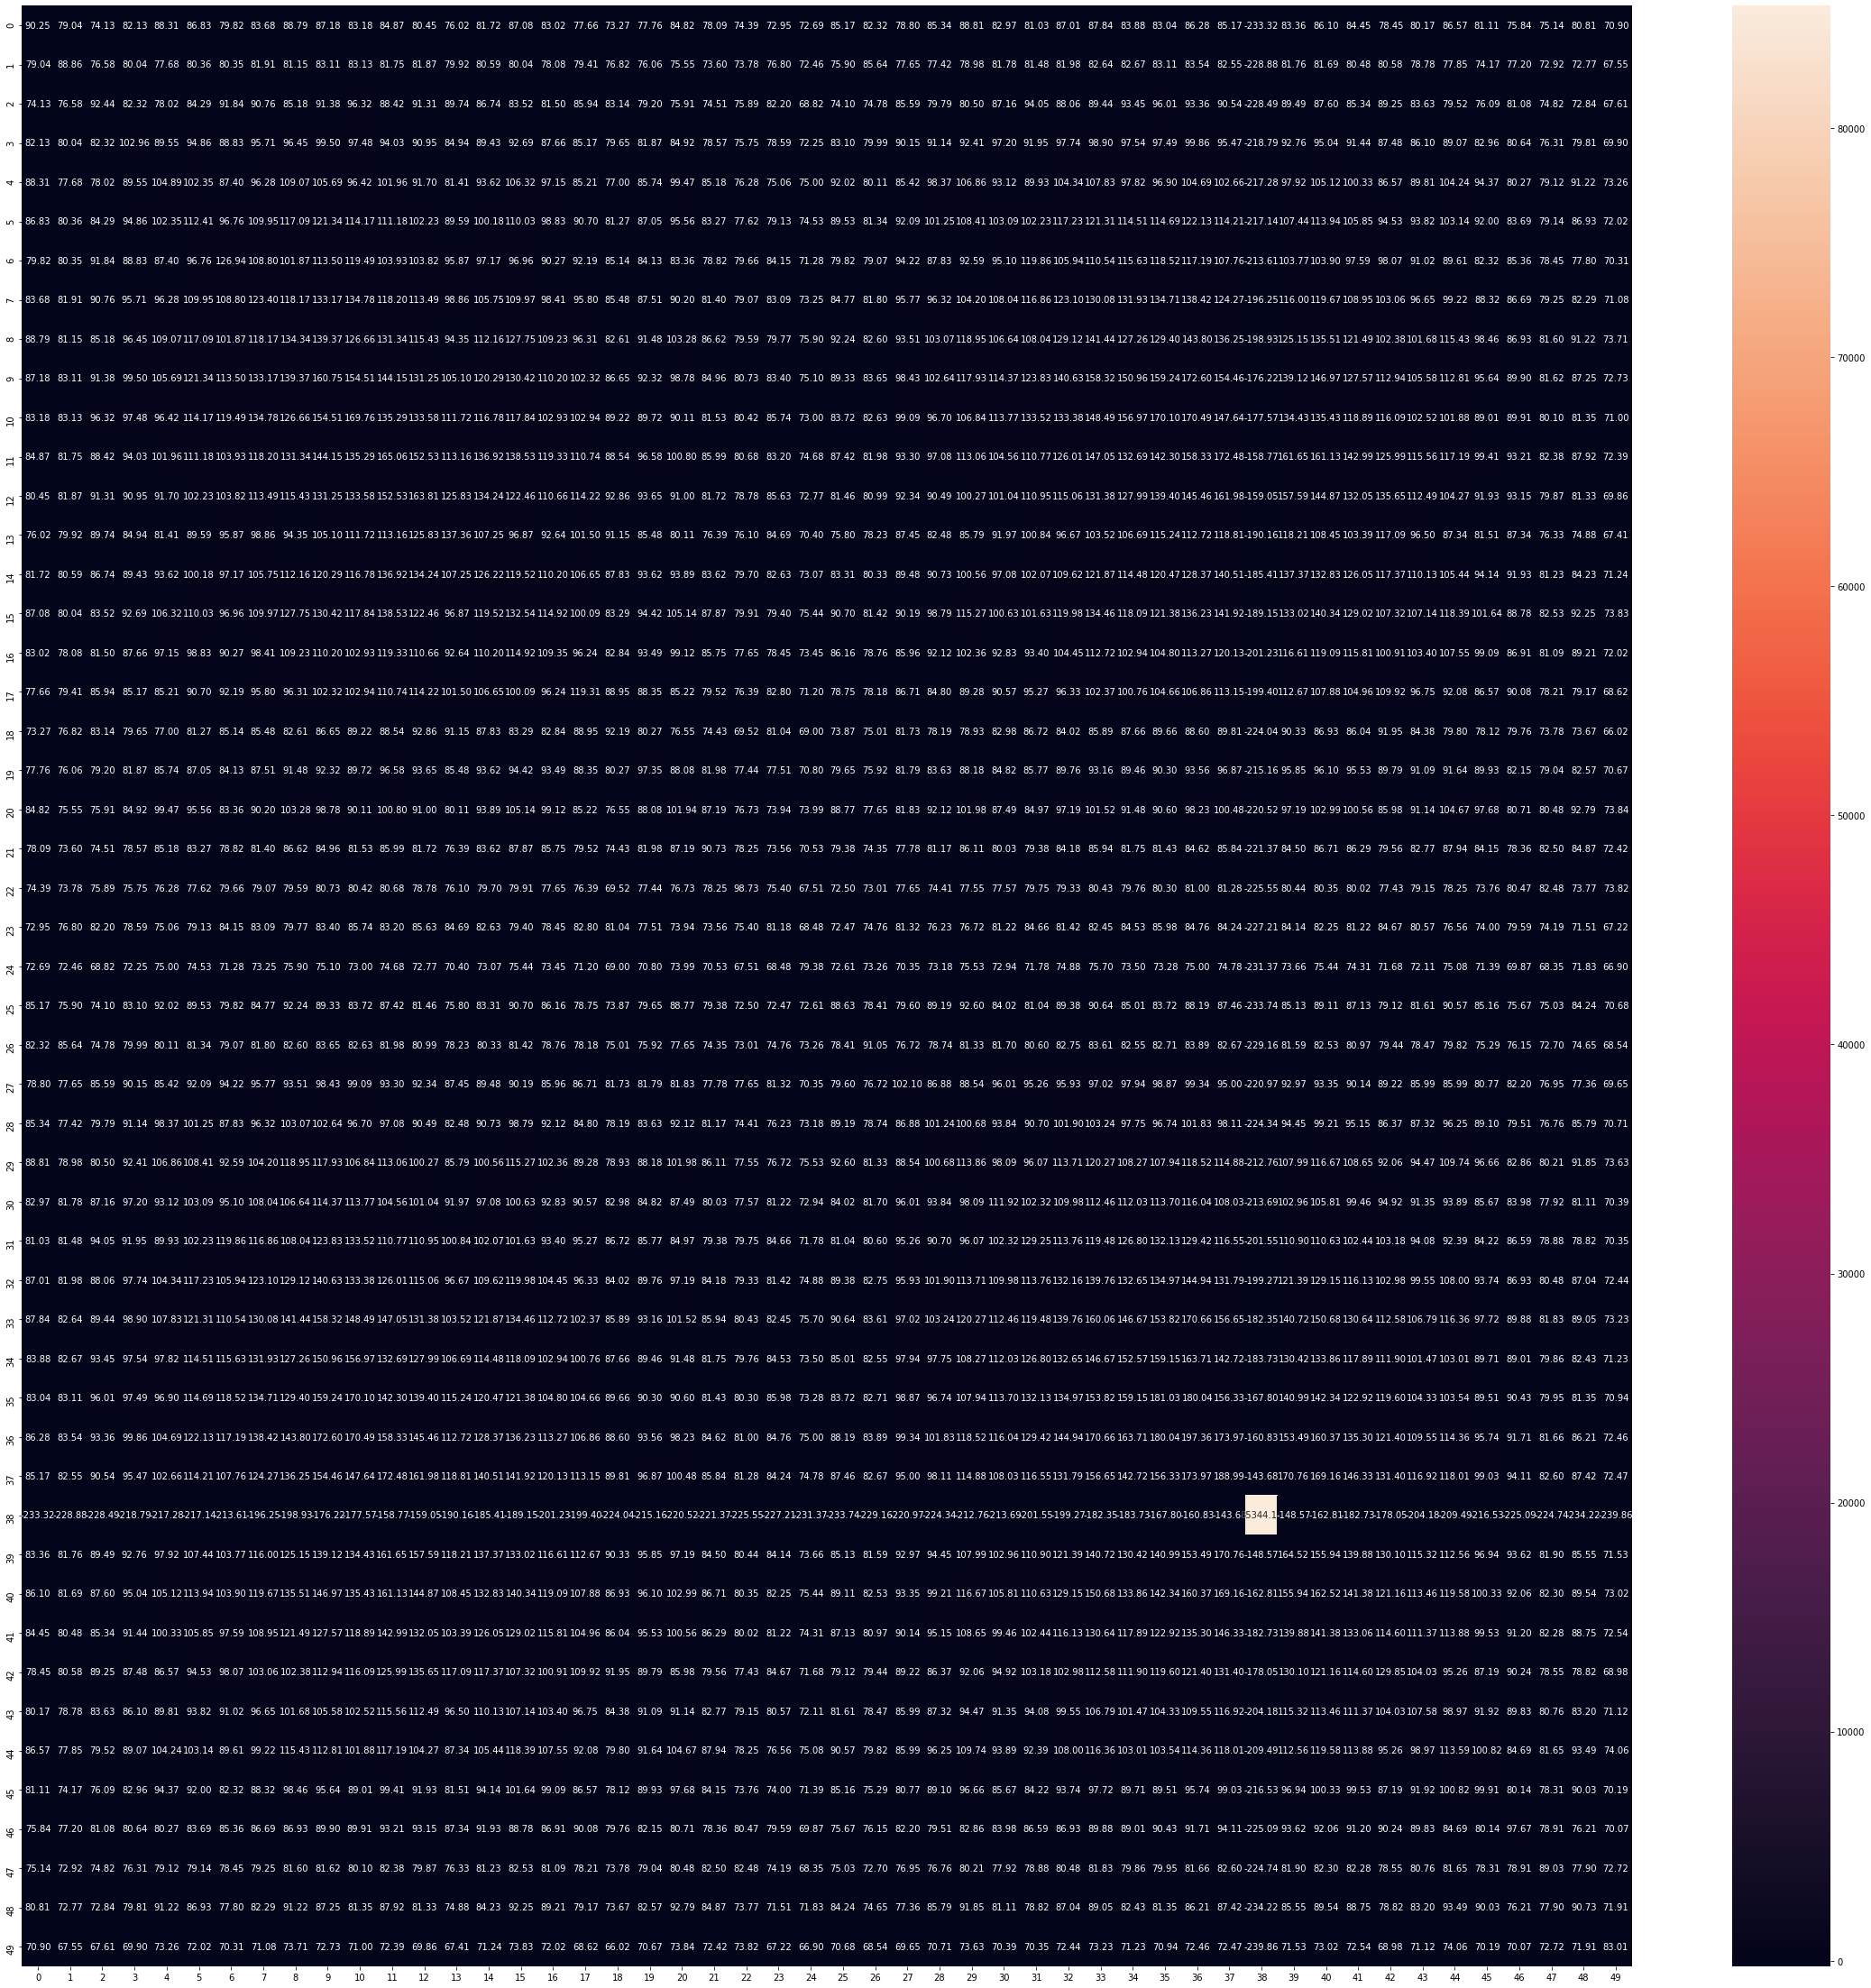

In [10]:
classes = np.array_split(data,5)
print(classes[0].shape)
print(classes[1].shape)
c1_cov_mean = np.mean(classes[0],axis=0)
plt.figure(figsize=(40, 40))
sns.heatmap(c1_cov_mean, annot=True, fmt='.2f')
plt.show()
# c2_cov_mean = np.mean(c1[1],axis=0)

In [11]:
labels = np.concatenate((np.zeros(500),np.ones(500),np.full(500,2),np.full(500,3),np.full(500,4)),axis=0)
print(labels)

[0. 0. 0. ... 4. 4. 4.]


In [12]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=5)
print(labels.shape,labels)

(2500, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
visible = Input(shape=(60,60))
cov1 = Conv1D(filters=60, kernel_size=2, activation="relu")(visible)
dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=60, kernel_size=4, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((56,60), name='newReshape')(dropout2)
f1 = Flatten()(newShape)
d1 = Dense(120, activation='relu')(f1)
d2 = Dense(120, activation='relu')(d1)
output = Dense(5, activation='softmax')(d2)
model = Model(inputs=visible, outputs=output)
model.summary()
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 59, 60)            7260      
_________________________________________________________________
dropout_11 (Dropout)         (None, 59, 60)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 56, 60)            14460     
_________________________________________________________________
dropout_12 (Dropout)         (None, 56, 60)            0         
_________________________________________________________________
newReshape (Reshape)         (None, 56, 60)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3360)              0   

In [14]:
data, labels = shuffle(data, labels)
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [15]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(500, 5) (500, 50, 50) (2000, 50, 50) (2000, 5)


In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)
model.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
32/32 [==============================] - 2s 38ms/step - loss: 224.0133 - accuracy: 0.1977 - val_loss: 8.6167 - val_accuracy: 0.1500
Epoch 2/100
32/32 [==============================] - 1s 32ms/step - loss: 644.7268 - accuracy: 0.2008 - val_loss: 7.0179 - val_accuracy: 0.2240
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 54.0606 - accuracy: 0.1950 - val_loss: 5.7488 - val_accuracy: 0.2600
Epoch 4/100
32/32 [==============================] - 1s 32ms/step - loss: 134.9785 - accuracy: 0.1922 - val_loss: 5.2007 - val_accuracy: 0.2860
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 330.0246 - accuracy: 0.2052 - val_loss: 4.9225 - val_accuracy: 0.3060
Epoch 6/100
32/32 [==============================] - 1s 32ms/step - loss: 43.2633 - accuracy: 0.2240 - val_loss: 4.9163 - val_accuracy: 0.3040
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 21.6730 - accuracy: 0.2122 - val_loss: 5.0418 - val_accuracy: 0.

In [ ]:
predictions = model.predict(x_test)
np.round(predictions)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

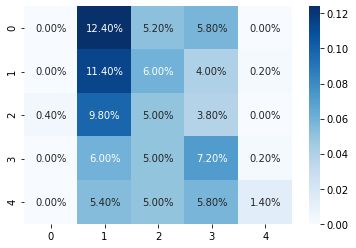

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
gru1 = GRU(60,activation="relu",return_sequences=True)(model.input)
dropout3 = Dropout(0.25)(gru1)
gru2 = GRU(60,activation="relu")(dropout3)
dropout4 = Dropout(0.5)(gru2)
d3 = Dense(60, activation='relu')(dropout4)
d4 = Dense(60, activation='relu')(d3)
output = Dense(5, activation='softmax')(d4)
model2 = Model(inputs=model.input, outputs=output)
model2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 60)            21960     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_22 (Dense)             (None, 60)                3660

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)
model2.fit(train_data,train_labels,validation_data=(x_test, y_test),batch_size=64,epochs=100, verbose=1)

Epoch 1/100
32/32 [==============================] - 6s 112ms/step - loss: 176.4911 - accuracy: 0.1997 - val_loss: 1239.6282 - val_accuracy: 0.1760
Epoch 2/100
32/32 [==============================] - 3s 91ms/step - loss: 29.3241 - accuracy: 0.2015 - val_loss: 1209.5834 - val_accuracy: 0.1800
Epoch 3/100
32/32 [==============================] - 3s 90ms/step - loss: 326.1582 - accuracy: 0.2082 - val_loss: 1195.1971 - val_accuracy: 0.1800
Epoch 4/100
32/32 [==============================] - 3s 89ms/step - loss: 56.8710 - accuracy: 0.2100 - val_loss: 1182.3572 - val_accuracy: 0.1680
Epoch 5/100
32/32 [==============================] - 3s 90ms/step - loss: 71.7504 - accuracy: 0.2008 - val_loss: 1161.5828 - val_accuracy: 0.1740
Epoch 6/100
32/32 [==============================] - 3s 90ms/step - loss: 72.2662 - accuracy: 0.2079 - val_loss: 1137.1774 - val_accuracy: 0.1780
Epoch 7/100
32/32 [==============================] - 3s 90ms/step - loss: 729.0214 - accuracy: 0.2208 - val_loss: 1139.98

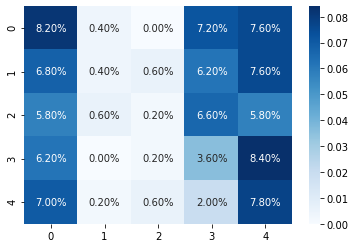

In [ ]:
predictions = model2.predict(x_test)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
for layer in model.layers:
  layer.trainable = False

for layer in model2.layers:
  layer.trainable = False

In [ ]:
def createFeatureModel(modelCNN, modelRNN):
  outputs = [modelCNN.layers[8].output,modelRNN.layers[6].output]
  merge = concatenate(outputs)
  featureModel = Model(inputs=modelCNN.input, outputs=merge)
  return featureModel

In [ ]:
def extractFeatures(model, data):
  features = model.predict(data,verbose=0)
  return features

In [ ]:
featureModel = createFeatureModel(model,model2)
train_features = extractFeatures(featureModel, train_data)
test_features = extractFeatures(featureModel, x_test)
print(train_features.shape, test_features.shape)

(2000, 180) (500, 180)


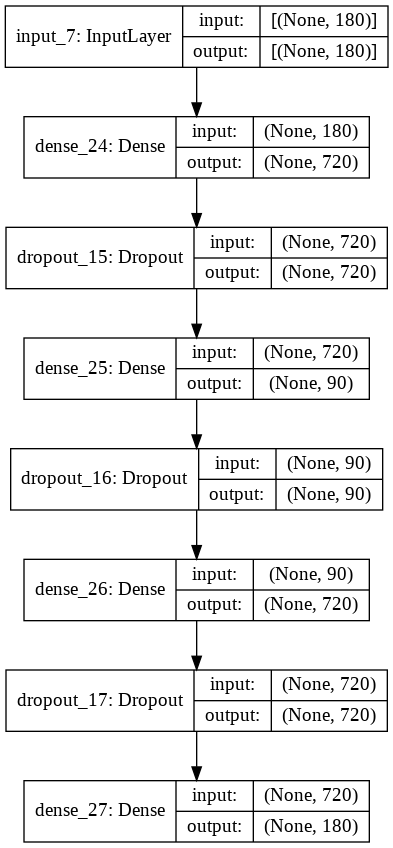

In [ ]:
daevisible = Input(shape=(180,))

encoder1 = Dense(720, activation='relu')(daevisible)
dropout5 = Dropout(0.25)(encoder1)
encoder2 = Dense(90, activation='sigmoid')(dropout5)
dropout6 = Dropout(0.25)(encoder2)
decoder1 = Dense(720, activation='relu')(dropout6)
dropout7 = Dropout(0.25)(decoder1)
decoder2 = Dense(180, activation='tanh')(dropout7)
model3 = Model(inputs=daevisible, outputs=decoder2)
plot_model(model3, show_shapes=True, to_file='model_graph.png')

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model3.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
history = model3.fit(x=train_features, y=train_features,epochs=200,batch_size=64,validation_data=(test_features, test_features),verbose=1)

Epoch 1/200
32/32 [==============================] - 1s 22ms/step - loss: 8256980.9899 - accuracy: 0.0094 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 78295860.9266 - accuracy: 0.0213 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 3/200
32/32 [==============================] - 0s 12ms/step - loss: 17163235.3820 - accuracy: 0.0360 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 4601695.0654 - accuracy: 0.0643 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 5/200
32/32 [==============================] - 0s 12ms/step - loss: 69681224.8875 - accuracy: 0.0698 - val_loss: 659213184.0000 - val_accuracy: 0.0000e+00
Epoch 6/200
32/32 [==============================] - 0s 11ms/step - loss: 5736597.8401 - accuracy: 0.0985 - val_loss: 659213184.0000 - val_accuracy: 0.1040
Epoch 7/200
32/32 [======================

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))    
    print('Mean for anomaly scores: ', np.mean(loss))
    return loss

In [ ]:
predictionsDAE = model3.predict(test_features,verbose=1)
scores = anomalyScores(test_features,predictionsDAE)

16/16 [==============================] - 0s 2ms/step
Mean for anomaly scores:  0.002000002


In [ ]:
encoder = Model(model3.input, model3.layers[3].output)
predictedFeatures = encoder.predict(train_features)
print(predictedFeatures.shape,train_features.shape)

(2000, 90) (2000, 180)


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 60)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 59, 60)       7260        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 59, 60)       0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 56, 60)       14460       dropout_11[0][0]                 
___________________________________________________________________________________________

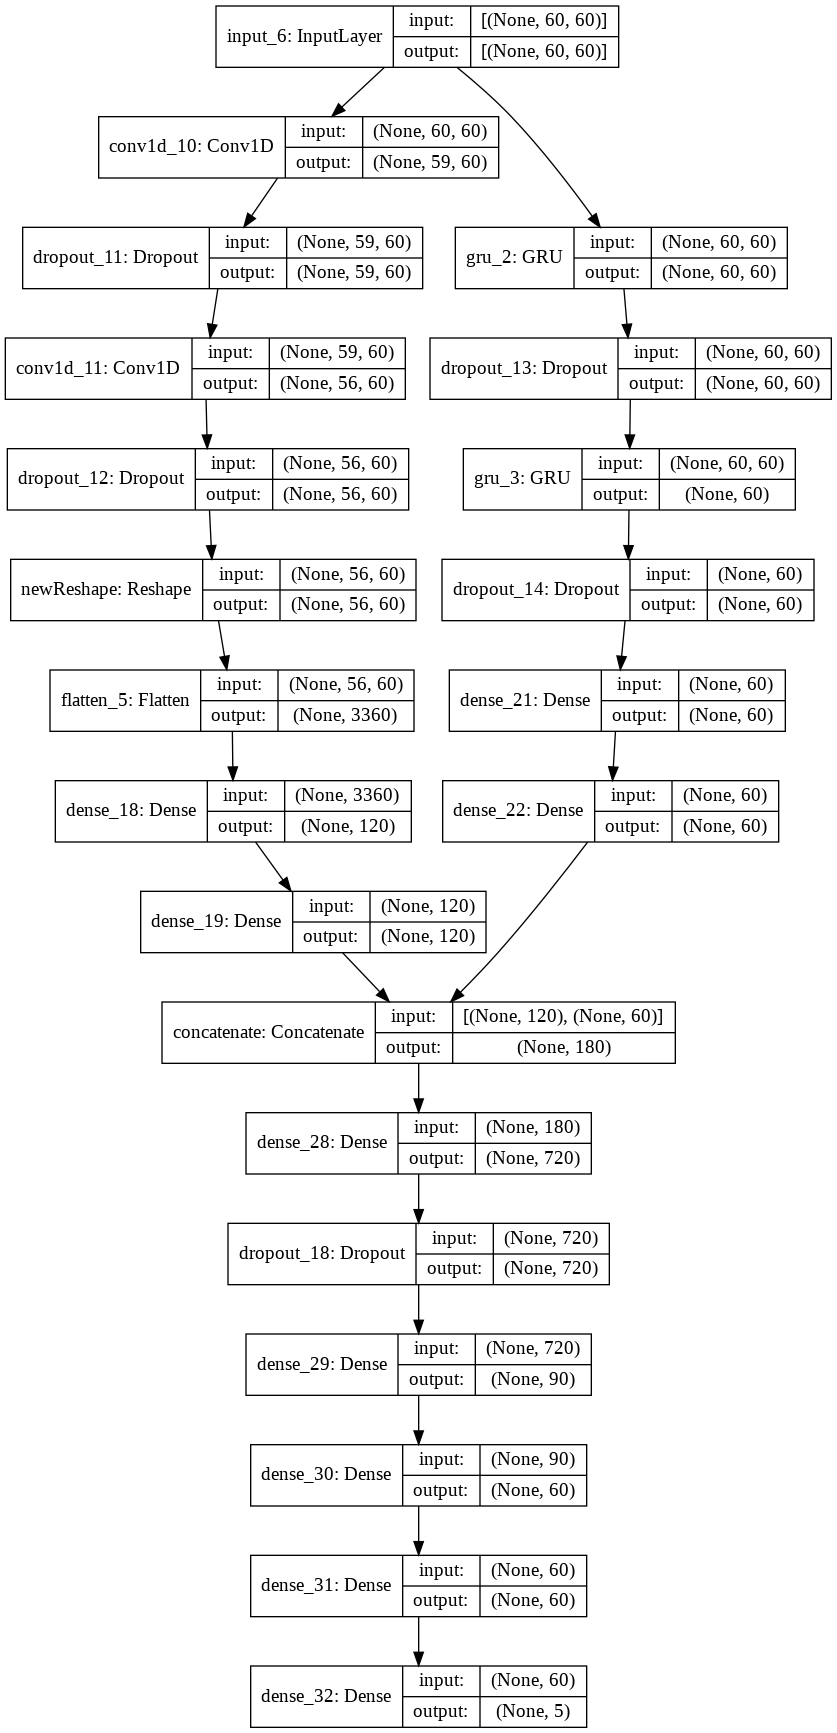

In [ ]:
featureOutput = featureModel.output
encoder1 = Dense(720, activation='relu')(featureOutput)
dropout5 = Dropout(0.25)(encoder1)
encoder2 = Dense(90, activation='sigmoid')(dropout5)
hidden1 = Dense(60, activation='relu')(encoder2)
hidden2 = Dense(60, activation='relu')(hidden1)
outputLayer = Dense(5, activation='softmax')(hidden2)
finalModel = Model(inputs=featureModel.input, outputs=outputLayer)
finalModel.summary()
plot_model(finalModel, show_shapes=True, to_file='model_graph.png')

In [ ]:
finalModel.layers[15].trainable = False
finalModel.layers[16].set_weights(model3.layers[1].get_weights())
finalModel.layers[16].trainable = False
finalModel.layers[17].set_weights(model3.layers[2].get_weights())
finalModel.layers[17].trainable = False
finalModel.layers[18].set_weights(model3.layers[3].get_weights())
finalModel.layers[18].trainable = False
finalModel.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60, 60)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 59, 60)       7260        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 59, 60)       0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 56, 60)       14460       dropout_11[0][0]                 
___________________________________________________________________________________________

In [ ]:
optimizer = Adam(learning_rate=0.00001)
finalModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_data, train_labels = shuffle(train_data, train_labels)
history = finalModel.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=200,verbose=1)

Epoch 1/200
32/32 [==============================] - 5s 81ms/step - loss: 1.9638 - accuracy: 0.2040 - val_loss: 1.9608 - val_accuracy: 0.1760
Epoch 2/200
32/32 [==============================] - 2s 69ms/step - loss: 1.9274 - accuracy: 0.2076 - val_loss: 1.9155 - val_accuracy: 0.1760
Epoch 3/200
32/32 [==============================] - 2s 64ms/step - loss: 1.8927 - accuracy: 0.1894 - val_loss: 1.8762 - val_accuracy: 0.1760
Epoch 4/200
32/32 [==============================] - 2s 64ms/step - loss: 1.8644 - accuracy: 0.1861 - val_loss: 1.8403 - val_accuracy: 0.1760
Epoch 5/200
32/32 [==============================] - 2s 60ms/step - loss: 1.8225 - accuracy: 0.1981 - val_loss: 1.8093 - val_accuracy: 0.1760
Epoch 6/200
32/32 [==============================] - 2s 64ms/step - loss: 1.7658 - accuracy: 0.2126 - val_loss: 1.7813 - val_accuracy: 0.1760
Epoch 7/200
32/32 [==============================] - 2s 64ms/step - loss: 1.7566 - accuracy: 0.1995 - val_loss: 1.7573 - val_accuracy: 0.1760
Epoch 

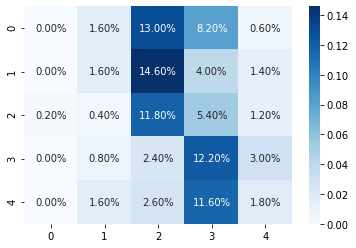

In [ ]:
predictions = finalModel.predict(x_test,verbose=0)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [16]:
train_data, train_labels = shuffle(train_data, train_labels)

In [18]:
visible = Input(shape=(50,50))
#CNN
cov1 = Conv1D(filters=50, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=50, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((46,50), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(100, activation='relu')(f1)
d2 = Dense(100, activation='relu')(d1)

#RNN
lstm1 = GRU(50,activation="relu",return_sequences=True)(visible)
lstm2 = GRU(50,activation="relu")(lstm1)
d3 = Dense(50, activation='relu')(lstm2)
d4 = Dense(50, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(600, activation='relu')(merge)
encoder2 = Dense(75, activation='relu')(encoder1)
decoder1 = Dense(600, activation='relu')(encoder2)
decoder2 = Dense(150, activation='relu')(decoder1)

#FNN
hidden1 = Dense(60, activation='relu')(encoder2)
hidden2 = Dense(60, activation='relu')(hidden1)
output = Dense(5, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 49, 50)       5050        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 46, 50)       10050       conv1d_2[0][0]                   
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 46, 50)       0           conv1d_3[0][0]                   
______________________________________________________________________________________________

In [19]:
optimizer = Adam(learning_rate=0.00001)

In [20]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
train_data, train_labels = shuffle(train_data, train_labels)

In [22]:
print(train_labels.shape,train_data.shape)

(2000, 5) (2000, 50, 50)


In [23]:
train_data, train_labels = shuffle(train_data, train_labels)  
history = model.fit(train_data,train_labels,validation_data=(x_test,y_test),epochs=200,verbose=1)


Epoch 1/200
63/63 [==============================] - 8s 72ms/step - loss: 63.0753 - accuracy: 0.2073 - val_loss: 2.1387 - val_accuracy: 0.2200
Epoch 2/200
63/63 [==============================] - 4s 63ms/step - loss: 160.2159 - accuracy: 0.2412 - val_loss: 1.8968 - val_accuracy: 0.2380
Epoch 3/200
63/63 [==============================] - 4s 65ms/step - loss: 27.2804 - accuracy: 0.2688 - val_loss: 1.8110 - val_accuracy: 0.2540
Epoch 4/200
63/63 [==============================] - 4s 65ms/step - loss: 1.8262 - accuracy: 0.2857 - val_loss: 1.6969 - val_accuracy: 0.2880
Epoch 5/200
63/63 [==============================] - 4s 64ms/step - loss: 1.6592 - accuracy: 0.3058 - val_loss: 1.6144 - val_accuracy: 0.3100
Epoch 6/200
63/63 [==============================] - 4s 66ms/step - loss: 1.6232 - accuracy: 0.3191 - val_loss: 1.5602 - val_accuracy: 0.2840
Epoch 7/200
63/63 [==============================] - 4s 65ms/step - loss: 1.5505 - accuracy: 0.3484 - val_loss: 1.5182 - val_accuracy: 0.3000
Ep

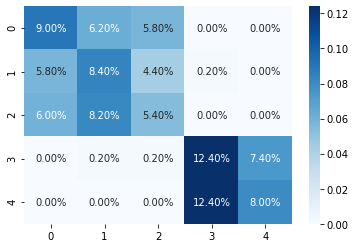

In [ ]:
predictions = model.predict(x_test,verbose=0)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

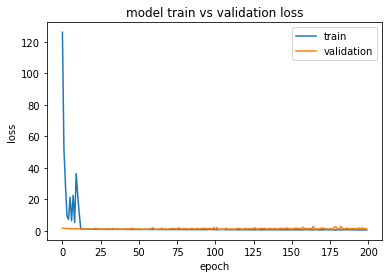

In [ ]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [ ]:
model.save("imagined_speech_model.h5")

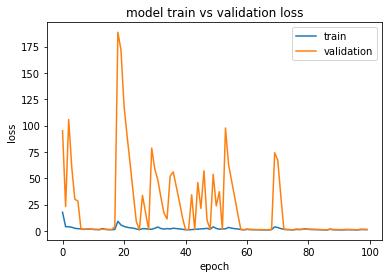

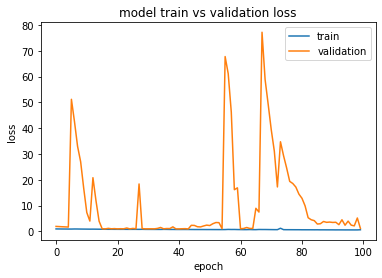

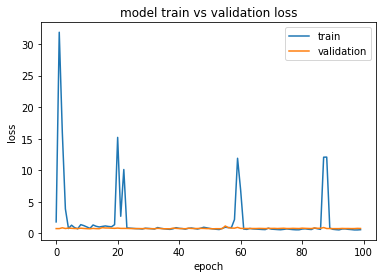

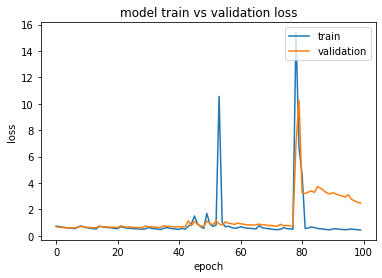

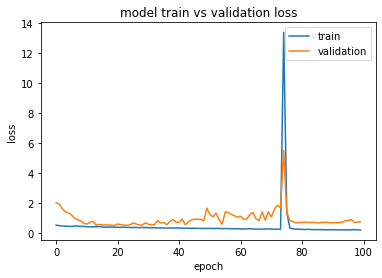

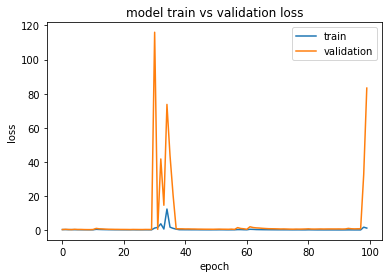

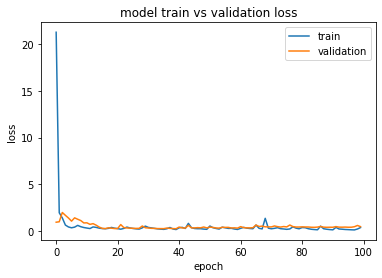

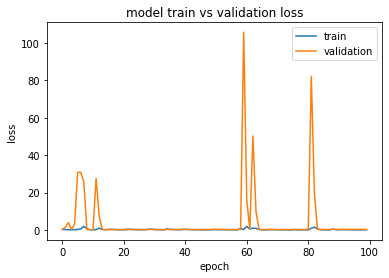

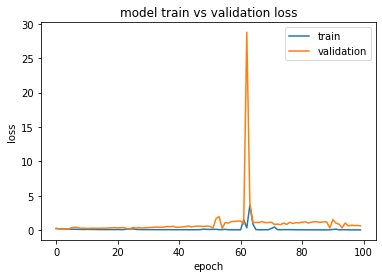

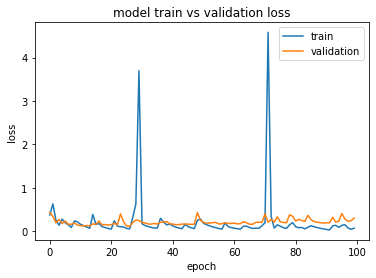

In [ ]:
for history in histories:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

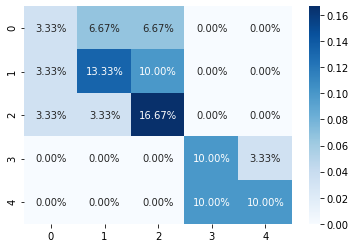

In [ ]:
  predictions_test = model.predict(x_test,verbose=0)
  np.round(predictions_test)
  rounded_labels_test = np.argmax(y_test, axis=1)
  rounded_predictions_test = np.argmax(predictions_test, axis=1)
  cf_test = confusion_matrix(rounded_labels_test,rounded_predictions_test)  # doctest: +SKIP
  sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap='Blues')
